<a href="https://colab.research.google.com/github/BoekhovenLab/Catalyst-poisoning/blob/main/Fit_Kinetics_symmetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
# @title Install packages { display-mode: "form" }
#Functions
%%capture
!pip install lmfit
!pip install numdifftools
from scipy.integrate import odeint, solve_ivp, lsoda
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from lmfit import Parameters, minimize, Model, report_fit, conf_interval
from sklearn.metrics import mean_squared_error
import numdifftools
from PIL import Image
from sklearn.metrics import r2_score
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.optimize
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tkr
import scipy.stats as st
from scipy.stats import scoreatpercentile




In [2]:
#@markdown # Define your style
Context = "talk" #@param ["notebook", "poster", "talk"]
Style = "ticks" #@param [ "darkgrid" , "whitegrid" , "dark" , "white" , "ticks"]
Font_Scale = .8 #@param {type:"number"}
Linewidth = 1.6 #@param {type:"number"}
Axis_linewidth = 1.6 #@param {type:"number"}
colors = [ "#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#999999","#F0E442","#0072B2", "#D55E00" ]
palette = sns.color_palette(colors)

#Palette = "tab20" #@param ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
sns.set_theme(context=Context, style=Style,
              font_scale=Font_Scale,
              rc={"lines.linewidth": Linewidth, 'axes.linewidth':Axis_linewidth,
                                  "xtick.major.width":Axis_linewidth,
                  "ytick.major.width":Axis_linewidth},
              palette = palette)



# Symmetric anhydride

In [3]:
#@title Install functions for kinetic analysis

def symmetric(z, t, k0, k1, k2, k3, k4, k5):

    """
    takes a vector of the initial concentrations that are previously defined.
    YOu have to provide also initial guesses for the kinetic constants.
    You must define as much constants as your system requires. Note that the reactions are expressed as differential
    equations

    F: Fuel
    Ac: Precursor
    An: Anhydride
    W: Waste
    N: N-acylurea

    Time is considered to be in **minutes**. Concentrations are in **mM**

    For the reaction kinetics, we use the steady-state approximation on O-acylurea. We consider dOacylurea/dt ~ 0, then we re
    """
    F, Ac, An, W, N = z

    dAcdt = -k1*Ac*F + 2*k4*An + ((k3*k1*Ac*F)/(k3+k5+(k2*Ac))) - ((k2*k1*Ac*Ac*F)/(k3+k5+(k2*Ac)))
    dFdt = -k1*Ac*F -k0*F
    dWdt = k0*F + ((((k2*Ac)+k3)*k1*Ac*F)/((k2*Ac)+k2+k3))
    dAndt = ((k2*k1*Ac*Ac*F)/(k3+k5+(k2*Ac))) - k4*An
    dNdt = ((k5*k1*Ac*F)/(k3+k5+(k2*Ac)))

    return [dFdt,dAcdt,dAndt,dNdt, dWdt]

def ode_solver_symmetric(t, initial_conditions, params):
    """
    Solves the ODE system given initial conditions for both initial concentrations and initial guesses for k



    """
    F, Ac, An, W, N = initial_conditions
    k0, k1, k2, k3, k4, k5 = params['k0'].value, params['k1'].value, params['k2'].value, params['k3'].value, params['k4'].value, params['k5'].value
    res = odeint(symmetric, [F, Ac, An, W, N], t, args=(k0, k1, k2, k3, k4, k5))

    return res

def kinetic_plotting_symmetric(z, t, params):


    """

    This is a complementary function that is similar to symmetric. Is only used for doing the plotting and simulating data.
    Time is in **minutes**. Concentrations are in **mM**


    """
    F, Ac, An, W, N = z
    k0, k1, k2, k3, k4, k5 = params
    dAcdt = -k1*Ac*F + 2*k4*An + ((k3*k1*Ac*F)/(k3+k5+(k2*Ac))) - ((k2*k1*Ac*Ac*F)/(k3+k5+(k2*Ac)))
    dFdt = -k1*Ac*F -k0*F
    dWdt = k0*F + ((((k2*Ac)+k3)*k1*Ac*F)/((k2*Ac)+k2+k3))
    dAndt = ((k2*k1*Ac*Ac*F)/(k3+k5+(k2*Ac))) - k4*An
    dNdt = ((k5*k1*Ac*F)/(k3+k5+(k2*Ac)))

    return [dFdt,dAcdt,dAndt,dNdt, dWdt]

def error(params, initial_conditions, tspan, data):
    sol = ode_solver_symmetric(tspan, initial_conditions, params)
    return (sol-data).ravel()

def MAE(params, initial_conditions, t, data): #mean absolute error
    sol = ode_solver_symmetric(t, initial_conditions, params)
    return (np.mean(np.abs(sol - data), axis=0))

def MAPE(params, initial_conditions, t, data): #mean absolute percentaje error
    sol = ode_solver_symmetric(t, initial_conditions, params)
    return (np.mean(np.abs((sol - data) / data) * 100, axis=0))

def r2error(params, initial_conditions, t, data): # r2 error
    sol = ode_solver_symmetric(t, initial_conditions, params)
    y_bar = np.mean(data, axis=0)
    SS_tot = np.sum((data - y_bar)**2, axis=0)
    SS_res = np.sum((sol - data)**2, axis=0)
    r_squared = 1 - SS_res / SS_tot
    return (1 - r_squared)*(data-sol)

def RMSEerror(params, initial_conditions, t, data): # Root-mean-square deviation

    sol = ode_solver_symmetric(t, initial_conditions, params)
    return (np.sqrt(np.mean((sol - data)**2, axis=0)))



def load_initial_conditions(df, k0):


    """

    Provided a dataframe we extract the initial concentrations, the time window and provide initial guesses for the kinetic modelling.
    Note that one can modifify the boundaries of the kinetic constants.
    Provide a df with the proper formatting

    k0 is calculated elsewhere.

    """
    tspan = np.linspace(df["time"][0],float(df["time"].tail(1))+20,1000)
    F = df["F"][0]
    Ac = df["Ac"][0]
    An = df["An"][0]
    W = df["W"][0]
    N = df["N"][0]
    initial_conditions = [F, Ac, An, W, N]

    #initial guesses.

    k0 = k0
    k1 = 1e-4
    k2 = .1
    k3 = 1
    k4 = .1
    k5 = 1

    params = Parameters()
    params.add('k0', value=k0, vary = False)
    params.add('k1', value=k1, min =1e-6,  max = 10)
    params.add('k2', value=k2, min =1e-6,  max = 10)
    params.add('k3', value=k3, min =1e-6,  max = 10)
    params.add('k4', value=k4, min =1e-6,  max = 10)
    params.add('k5', value=k5, min =1e-6,  max = 10)

    return initial_conditions, params, tspan



def bt_fit(n_iter, df, method, error, initial_conditions, params, tspan):


    """
    We do bootstrapping with replacement in the experimental data and the we do the fitting on each resampled dataframe. We store the solutions for the k values.
    In the end we obtain a distribution of kinetic constants.
    One can also calcualate other parameters, for instance the half-life of the anhydride.


    n_iter: number of bootstrapping steps.
    df: parent dataframe
    method: Minimization method
    error: Loss function
    initial_conditions,
    params,
    tspan

    """
    data = df[['F', 'Ac', 'An', 'W', "N"]].values
    t = df['time']
    n_iter = n_iter
    k0_bt = []
    k1_bt = []
    k2_bt = []
    k3_bt = []
    k4_bt = []
    k5_bt = []
    half_life = []

    #k0 = k0
    for i in range(0, n_iter):
        bt = df.sample(n = len(df), replace=True).reset_index(drop = True)
        bt = bt.sort_values(by = "time")
        data = bt[[ 'F', 'Ac', 'An', "N",'W']].values
        t = bt['time']

        """
        This is the most crucial sentence of the code.
        It minimize out error function according to our initial values, guesses and time window.
        There are several algorithms to minimize the function.

        Here's a list of those available. Note that some of them may require long computation period.
        https://lmfit.github.io/lmfit-py/fitting.html

        """
        result = minimize(error, params,
                      args=(initial_conditions, t, data), method=method, nan_policy='omit')
        k0_bt.append(result.params['k0'].value)
        k1_bt.append(result.params['k1'].value)
        k2_bt.append(result.params['k2'].value)
        k3_bt.append(result.params['k3'].value)
        k4_bt.append(result.params['k4'].value)
        k5_bt.append(result.params['k5'].value)
        half_life.append(np.log(2)/(result.params['k4'].value))

        res = pd.DataFrame({"k0":k0,
                            "k1":k1_bt,
                           "k2":k2_bt,
                           "k3":k3_bt,
                           'k4':k4_bt,
                           "k5":k5_bt,
                            "half-life":half_life
                           })

    return res


def get_k_fitted(statistic, res, k0):


    """

    Provides the mean/median value of the distribution of the kinetic constants.
    Some k values have high uncertainty giving rise to non normal distribution of parameters. We believe the median reflects better this distribution of k values.
    statistics: mean, median
    res: result of the fitting

    """
    k0 = k0
    if statistic == "mean":
        k1 = float(res.k1.mean())
        k2 = float(res.k2.mean())
        k3 = float(res.k3.mean())
        k4 = float(res.k4.mean())
        k5 = float(res.k5.mean())
    elif statistic == "median":
        k1 = float(res.k1.median())
        k2 = float(res.k2.median())
        k3 = float(res.k3.median())
        k4 = float(res.k4.median())
        k5 = float(res.k5.median())
    else:
        print("I do not understand you")
    params = k0,k1,k2,k3,k4,k5
    return params

def get_fitted_curve(initial_conditions, tspan, params):
    """
    You provide the initial conditions, and the fitted values for the kinetic constants to simulate data.
    Is the "line" in the fitting curves.

    initial_conditions
    tspan: time window
    params: fitted parameters

    returns fitted data
    """

    y = pd.DataFrame(odeint(kinetic_plotting_symmetric, initial_conditions, tspan, args=(params,)), columns = ['F', 'Ac', 'An', "N",'W'])
    y['min'] = tspan
    return y

def get_r2(df_real, initial_conditions, params):

    """

    Calculates the goodness of the fit through the R2. Which is a well-known parameter to decide whether a fit
    was done properly. Ranges between 0 and 1. Close to 1 equals to good fitting.

    initial_conditions
    df_real: original data
    params: fitted parameters

    returns fitted data

    """
    y_real = df_real[['F', 'Ac', 'An', 'W', "N"]]
    t = df_real['time']
    y_predict = pd.DataFrame(odeint(kinetic_plotting_symmetric, initial_conditions, t, args = (params,)), columns = ['F', 'Ac', 'An', "N",'W'])

    r2_F = round(r2_score(y_real["F"], y_predict["F"]),4)
    r2_Ac = round(r2_score(y_real["Ac"], y_predict["Ac"]),4)
    r2_An = round(r2_score(y_real["An"], y_predict["An"]),4)
    r2_N = round(r2_score(y_real["N"], y_predict["N"]),4)

    r2 = [r2_F, r2_Ac, r2_An, r2_N]

    return r2

def get_rmse(df_real, initial_conditions, params):

    """

    Calculates the goodness of the fit through the R2. Which is a well-known parameter to decide whether a fit
    was done properly. Ranges between 0 and 1. Close to 1 equals to good fitting.

    initial_conditions
    df_real: original data
    params: fitted parameters

    returns fitted data

    """
    y_real = df_real[['F', 'Ac', 'An', 'W', "N"]]
    t = df_real['time']
    y_predict = pd.DataFrame(odeint(kinetic_plotting_symmetric, initial_conditions, t, args = (params,)), columns = ['F', 'Ac', 'An', "N",'W'])

    rmse_F = np.sqrt(np.mean((y_predict["F"] - y_real["F"])**2, axis=0))
    rmse_Ac = np.sqrt(np.mean((y_predict["Ac"] - y_real["Ac"])**2, axis=0))
    rmse_An = np.sqrt(np.mean((y_predict["An"] - y_real["An"])**2, axis=0))
    rmse_N = np.sqrt(np.mean((y_predict["N"] - y_real["N"])**2, axis=0))

    rmse = [rmse_F, rmse_Ac, rmse_An, rmse_N]

    return rmse

def plot_fitted(df, y):

    """

    Creates a 4 column plots. In each column there is a different reagent. It plots both the original data and
    the fitted

    df: data
    y: fitted


    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize = (15, 3.75),
                                    sharey = False, sharex = True)
    sns.scatterplot(data = df, x = 'time', y = 'F', ax = ax1, color = sns.color_palette(palette)[0], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'F', ax = ax1, alpha = 0.5, color = sns.color_palette(palette)[0])

    sns.scatterplot(data = df, x = 'time', y = 'Ac', ax = ax2, color = sns.color_palette(palette)[1], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'Ac', ax = ax2, alpha = 0.5, color = sns.color_palette(palette)[1])

    sns.scatterplot(data = df, x = 'time', y = 'An', ax = ax3, color = sns.color_palette(palette)[2], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'An', ax = ax3, alpha = 0.5, color = sns.color_palette(palette)[2])

    sns.scatterplot(data = df, x = 'time', y = 'N', ax = ax4, color = sns.color_palette(palette)[3], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'N', ax = ax4, alpha = 0.5, color = sns.color_palette(palette)[3])



    ax1.set(xlabel = 'Time [min]', ylabel = 'EDC [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax2.set(xlabel = 'Time [min]', ylabel = 'Acid [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax3.set(xlabel = 'Time [min]', ylabel = 'Anhydride [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax4.set(xlabel = 'Time [min]', ylabel = '$N$-acylurea [mM]', xticks = (0, 150, 300),xlim = (-20, 320))


    plt.tight_layout()

    return fig, (ax1, ax2, ax3, ax4)

def plot_fitted_error_2(df, y,rmse):


    """
    Creates a 4 column plots. In each column there is a different reagent. It plots both the original data and
    the fitted. Error is the 95 Confidence interval of the median. It is showed as filled area.

    df: data
    y: fitted
    y_max: upper limit
    y_min: low limit


    """

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize = (15, 3.75),
                                    sharey = False, sharex = True)
    sns.scatterplot(data = df, x = 'time', y = 'F', ax = ax1, alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'F', ax = ax1, alpha = 0.5, color = sns.color_palette(palette)[0])
    ax1.fill_between(tspan, y["F"]+(1.96*rmse[0]), y["F"]-(1.96*rmse[0]), alpha = 0.2, color = sns.color_palette(palette)[0], lw = 0)

    sns.scatterplot(data = df, x = 'time', y = 'Ac', ax = ax2, color = sns.color_palette(palette)[1], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'Ac', ax = ax2, alpha = 0.5, color = sns.color_palette(palette)[1])
    ax2.fill_between(tspan, y["Ac"]+(1.96*rmse[1]), y["Ac"]-(1.96*rmse[1]), alpha = 0.2, color = sns.color_palette(palette)[1], lw = 0)


    sns.scatterplot(data = df, x = 'time', y = 'An', ax = ax3, color = sns.color_palette(palette)[2], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'An', ax = ax3, alpha = 0.5, color = sns.color_palette(palette)[2])
    ax3.fill_between(tspan, y["An"]+(1.96*rmse[2]), y["An"]-(1.96*rmse[2]), alpha = 0.2, color = sns.color_palette(palette)[2], lw = 0)


    sns.scatterplot(data = df, x = 'time', y = 'N', ax = ax4, color = sns.color_palette(palette)[3], alpha = 0.85)
    sns.lineplot(data = y, x = 'min', y = 'N', ax = ax4, alpha = 0.5, color = sns.color_palette(palette)[3])
    ax4.fill_between(tspan, y["N"]+(1.96*rmse[3]), y["N"]-(1.96*rmse[3]), alpha = 0.2, color = sns.color_palette(palette)[3], lw = 0)


    ax1.set(xlabel = 'Time [min]', ylabel = 'EDC [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax2.set(xlabel = 'Time [min]', ylabel = 'Acid [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax3.set(xlabel = 'Time [min]', ylabel = 'Anhydride [mM]', xticks = (0, 150, 300),xlim = (-20, 320))
    ax4.set(xlabel = 'Time [min]', ylabel = '$N$-acylurea [mM]', xticks = (0, 150, 300),xlim = (-20, 320))



    plt.tight_layout()

    return fig, (ax1, ax2, ax3, ax4)



def make_figure(figures, name):

    """
    Useful to create single images with different png files.
    You provide the names of the png files and creates a new one.
    figures: list of png files
    name: Name of the output file.

    """
    # List of image filenames
    image_files = figures

    # Load images
    images = [Image.open(f) for f in image_files]

    # Determine the size of the final image
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)

    # Create a new image with the appropriate size
    new_image = Image.new('RGBA', (max_width, total_height), (255, 255, 255, 0))

    # Paste the individual images into the final image
    y_offset = 0
    for im in images:
        new_image.paste(im, (0, y_offset))
        y_offset += im.size[1]

    # Save the final image
    new_image.save(f'{name}.png', 'PNG', dpi=(300, 300)) # Resolution

At this point you have to upload the excel file template containing the experimental data.

In [4]:
# @title Loading functions
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

def load_data_frame(excel_name, sheet_name):

  a = pd.read_excel(f'{excel_name}.xlsx', sheet_name= f"{sheet_name}", skiprows=(range(0,2)))
  a.columns = ["time", "F", "Ac", "An", "N", "Condition"]
  a["W"] = a['F'][0]-a["F"] - a["N"]
  return a

def sort_condition(df):
  list_df = []
  conditions = df["Condition"].unique()
  for condition in conditions:
    g = df[df["Condition"] == condition].sort_values(by = ["time", "Condition"]).reset_index(drop = True)
    list_df.append(g)

  return list_df, conditions



Saving Template.xlsx to Template.xlsx
User uploaded file "Template.xlsx" with length 59561 bytes


In [5]:
# @title Load dataframe
# @markdown We select the sheet of interest

import ipywidgets as widgets
from IPython.display import display

excel_name = "Template" #@param {type:"string"}
sheets = pd.ExcelFile(f"{excel_name}.xlsx").sheet_names

sheet_dropdown = widgets.Dropdown(
    options=sheets,
    description='Select a sheet:',
    disabled=False
)

# Display the dropdown widget
display(sheet_dropdown)



Dropdown(description='Select a sheet:', options=('precursor_change', 'additives', 'pyridine', 'Temperature', '…

In [6]:
# Reload one you change sheet name above
df = load_data_frame(excel_name, sheet_dropdown.value)
dfs, cond = sort_condition(df)
cond

array(['triazole', 'pyridine', 'DMAP'], dtype=object)

In our case the excel file contains different sheets for different conditions tested i.e., pyridine, pH, T...

## Bootstrapping fitting

## Introduce the values of k0

The order for introducing k0 values is:

In [7]:
cond

array(['triazole', 'pyridine', 'DMAP'], dtype=object)

Introduce as much k0 values as conditions you are studying



In [8]:
k0s_input = [1.8e-4, 1.8e-4, 1.8e-4]

CPU times: user 6min 20s, sys: 9.44 s, total: 6min 29s
Wall time: 6min 24s


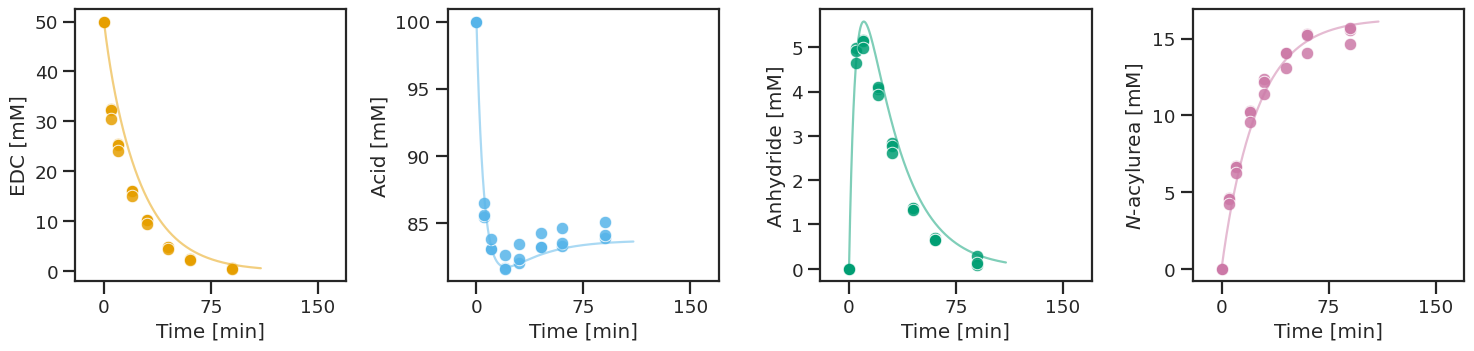

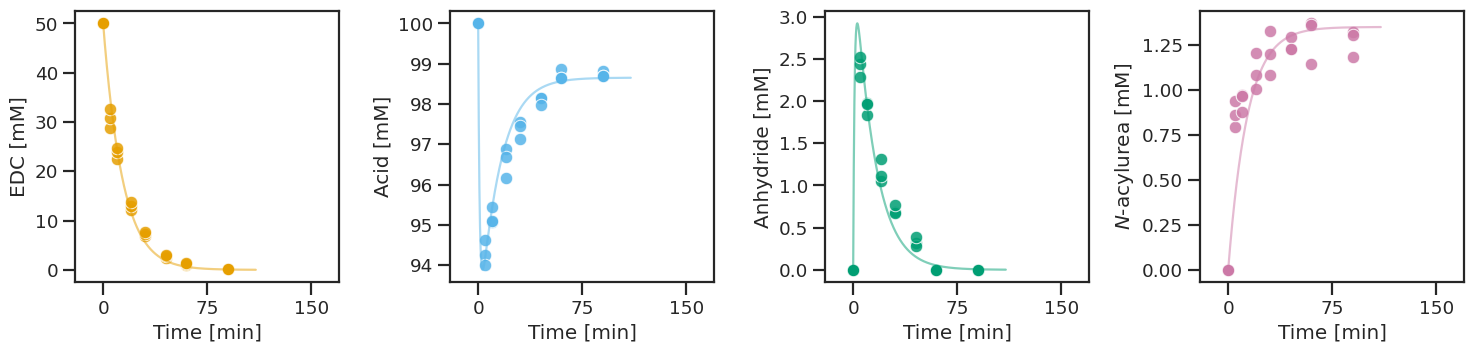

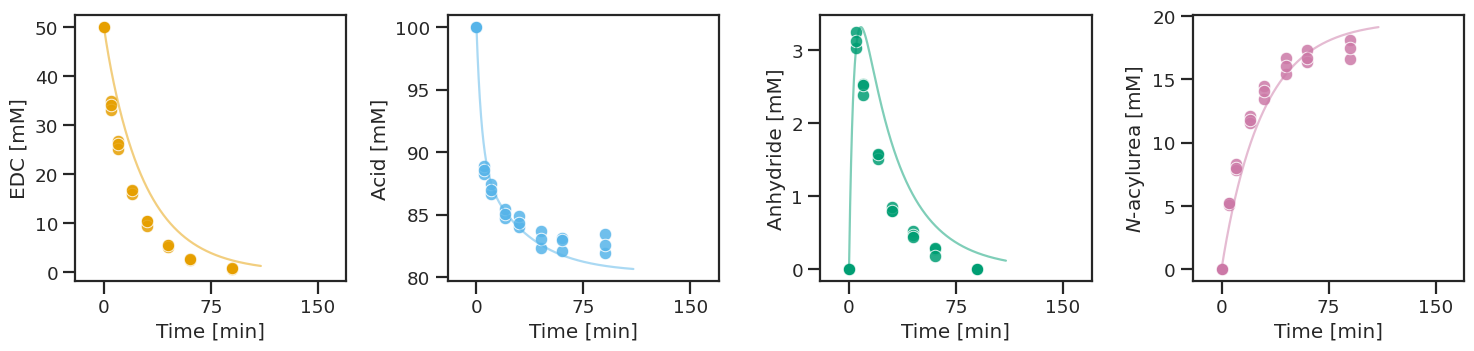

In [16]:
#@title Fit dataseries
#@markdown Fits and plots data
%%time
n_iter = 20 #@param {type:"integer"}
method_fitting = "least_squares" #@param ["least_squares", "leastsq", "nelder"]
error_function = RMSEerror #@param ["error", "MAE", "MAPE", "r2error", "RMSEerror"] {type:"raw"}
name_file = "Full_figure_additives" #@param {type:"string"}
save_plot = False #@param {type:"boolean"}
# @markdown You can change the x and y limits and the tick labels. Just get in the code and modify them.

if save_plot == True:
  summary = []
  r2s = []
  files_name = []

  for df, j, k0 in zip(dfs, cond, k0s_input):
      #plt.figure(figsize=(60, 60))
      initial_conditions, params, tspan = load_initial_conditions(df, k0)
      res = bt_fit(n_iter, df, method_fitting, error_function, initial_conditions, params, tspan)
      res["Condition"] = j
      summary.append(res)
      params = get_k_fitted("median", res, k0)
      y = get_fitted_curve(initial_conditions,tspan, params)
      data = df
      plot_fitted(df, y)
      r2 = get_r2(df, initial_conditions, params)
      r2s.append(r2)
      plt.xlim(-20,150)
      plt.xticks([0, 75, 170])
      files_name.append(f"name_file_{j}.png")
      plt.savefig(f"name_file_{j}.png", dpi = 300, bbox_inches = "tight", transparent = True)

  make_figure(files_name, name_file)


else:

  summary = []
  r2s = []

  for df, j, k0 in zip(dfs, cond, k0s_input):
      #plt.figure(figsize=(60, 60))
      initial_conditions, params, tspan = load_initial_conditions(df, k0)
      res = bt_fit(n_iter, df, method_fitting, error_function, initial_conditions, params, tspan)
      res["Condition"] = j
      summary.append(res)
      params = get_k_fitted("median", res, k0)
      y = get_fitted_curve(initial_conditions,tspan, params)
      data = df
      plot_fitted(df, y)
      r2 = get_r2(df, initial_conditions, params)
      r2s.append(r2)
      plt.xlim(-20,170)
      plt.xticks([0, 75, 150])


## R$^2$

In [17]:
fitting_results = pd.DataFrame(r2s, columns = ['F', 'Ac', 'An', 'N'],
                              index = cond)
fitting_results

,F,Ac,An,N
triazole,0.9017,0.9705,0.9545,0.9733
pyridine,0.9874,0.9670,0.9605,0.7617
DMAP,0.8646,0.9554,0.7178,0.9360


CPU times: user 6min 10s, sys: 9.44 s, total: 6min 20s
Wall time: 6min 13s


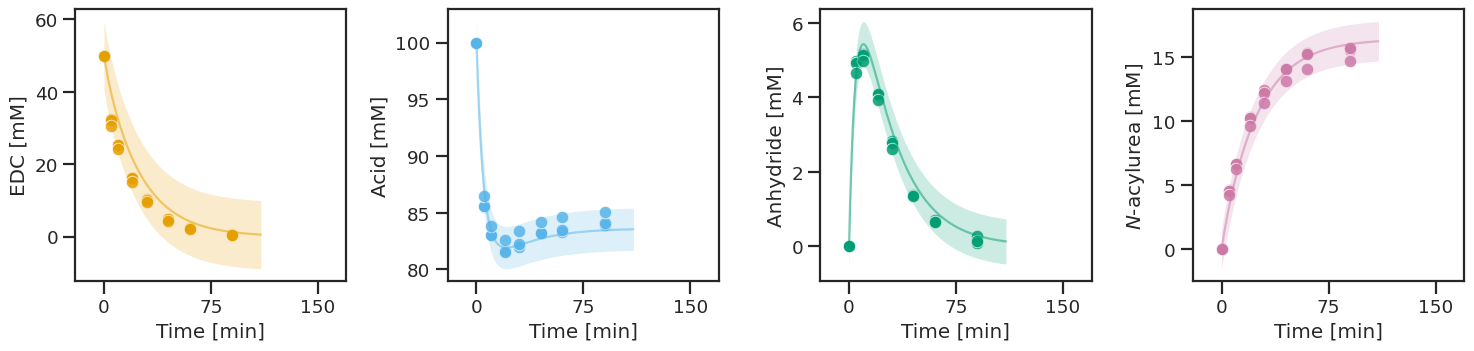

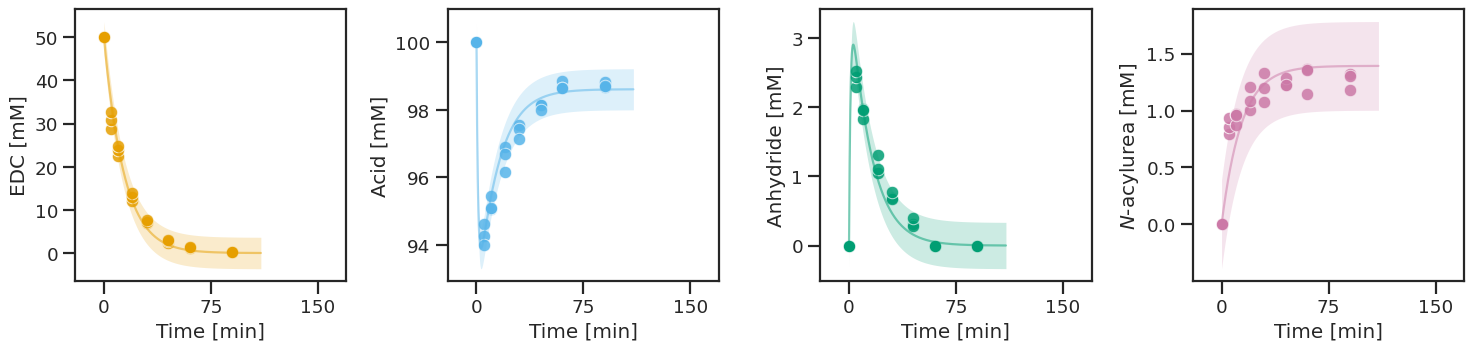

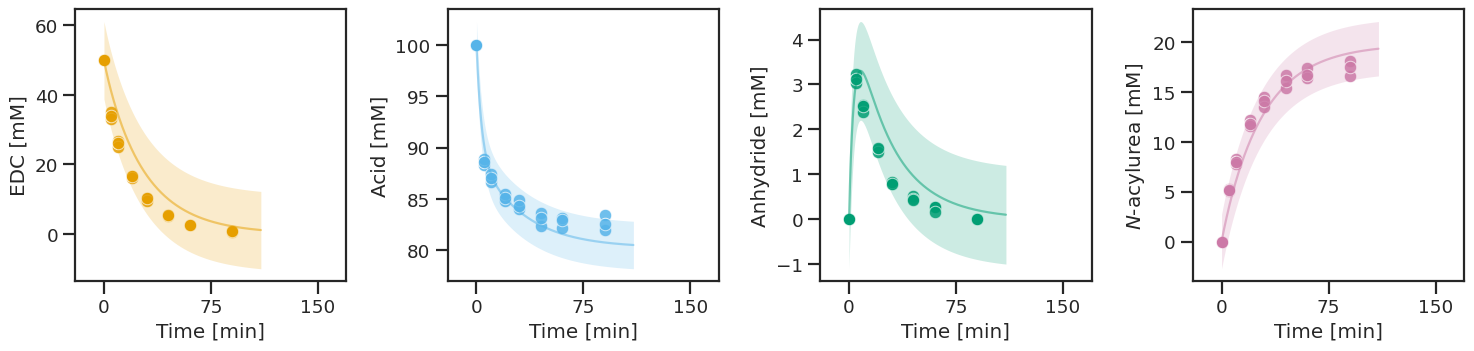

In [14]:
#@title Fit dataseries
#@markdown Fits and plots data  **CI (95 %)**
%%time
#n_iter = 20 #@param {type:"integer"}
#method_fitting = "least_squares" #@param ["least_squares", "leastsq", "nelder"]
#error_function = error #@param ["error", "MAE", "MAPE", "r2error", "RMSEerror"] {type:"raw"}
name_file = "Full_figure_additives" #@param {type:"string"}
save_plot = False #@param {type:"boolean"}


if save_plot == True:
    summary = []
    r2s = []
    rmses = []
    files_name = []


    for df, j, k0 in zip(dfs, cond, k0s_input):
        #plt.figure(figsize=(60, 60))
        initial_conditions, params, tspan = load_initial_conditions(df, k0)
        res = bt_fit(n_iter, df, method_fitting, error_function, initial_conditions, params, tspan)
        res["Condition"] = j
        summary.append(res)
        params = get_k_fitted("median", res, k0)
        y = get_fitted_curve(initial_conditions,tspan, params)
        rmse = get_rmse(df, initial_conditions, params)
        rmses.append(rmse)
        data = df
        plot_fitted_error_2(df, y, rmse)
        plt.xlim(-20,170)
        plt.xticks([0, 75, 150])
        files_name.append(f"name_file{j}.png")
        plt.savefig(f"name_file{j}.png", dpi = 300, bbox_inches = "tight", transparent = True)

    make_figure(files_name, name_file)
else:
    summary = []
    r2s = []
    rmses = []
    files_name = []
    for df, j, k0 in zip(dfs, cond, k0s_input):
        #plt.figure(figsize=(60, 60))
        initial_conditions, params, tspan = load_initial_conditions(df, k0)
        res = bt_fit(n_iter, df, method_fitting, error_function, initial_conditions, params, tspan)
        res["Condition"] = j
        summary.append(res)
        params = get_k_fitted("median", res, k0)
        y = get_fitted_curve(initial_conditions,tspan, params)
        rmse = get_rmse(df, initial_conditions, params)
        rmses.append(rmse)
        data = df
        plot_fitted_error_2(df, y, rmse)
        plt.xlim(-20,170)
        plt.xticks([0, 75, 150])





## Retrieve k values



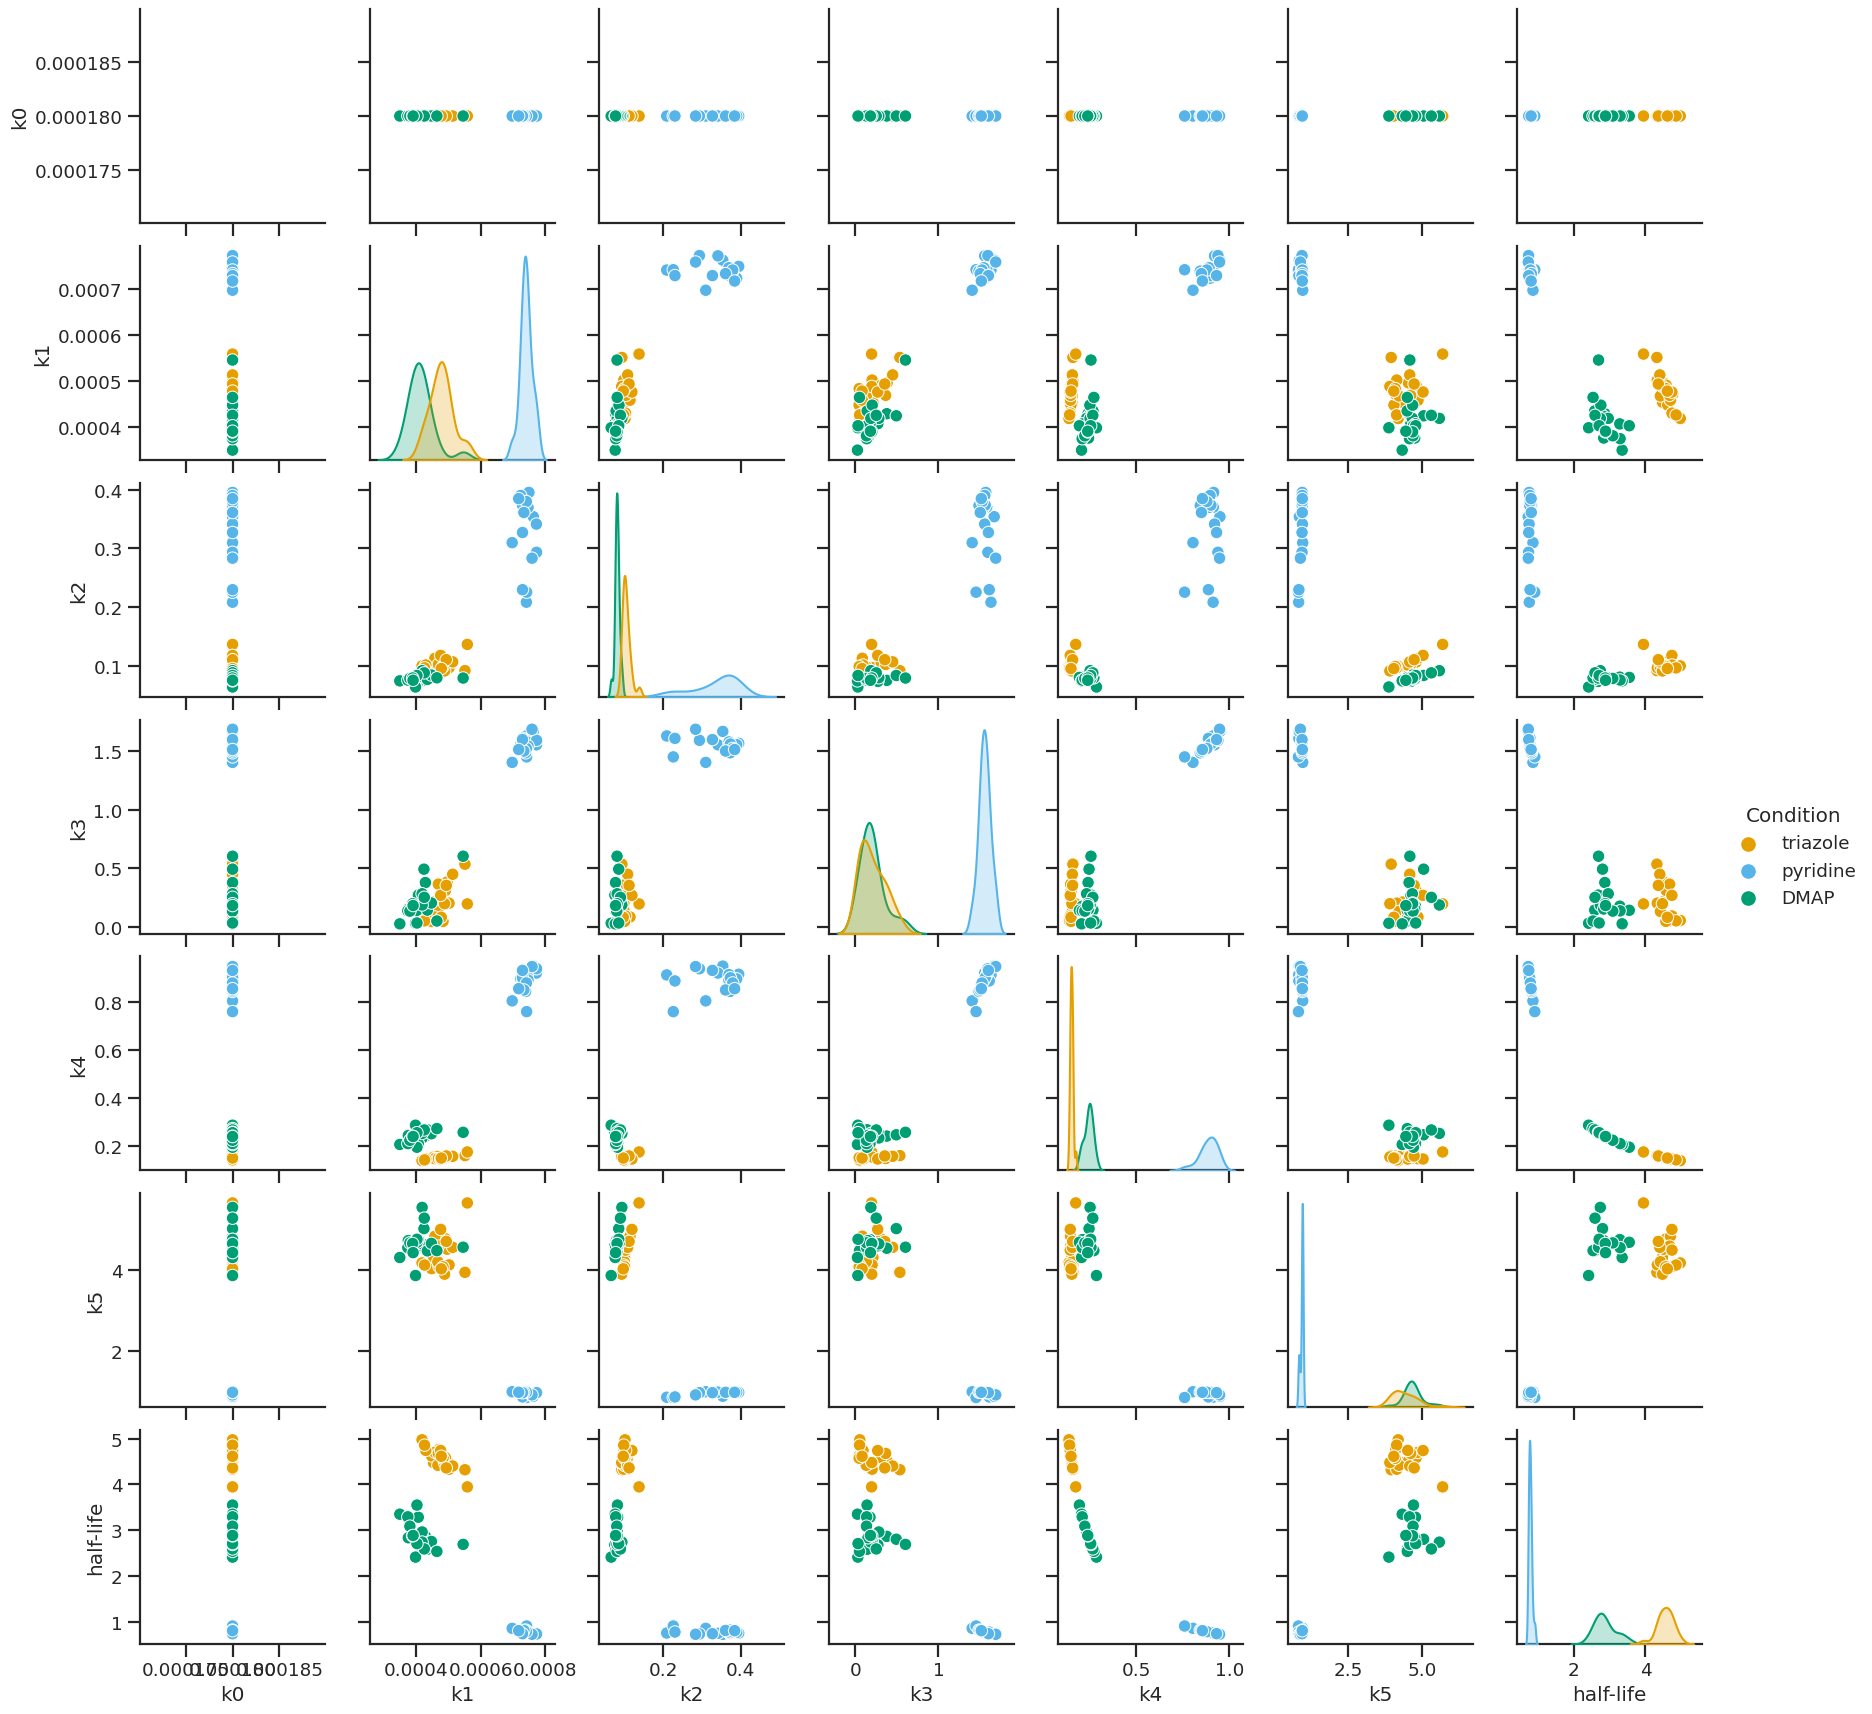

In [13]:
plot_k = True #@param {type:"boolean"}
save_plot = False #@param {type:"boolean"}
plot_name = "Additive_effect_constants" #@param {type:"string"}

r = pd.concat(objs = summary, axis = 0).reset_index(drop = True)

if plot_k == True:
  sns.pairplot(data = r, hue = "Condition",
                palette = colors[0: len(cond)])
  if save_plot == True:
    plt.savefig(f"{plot_name}scatter.png", dpi = 300, bbox_inches = "tight", transparent = True)
  else:
    pass
else:
  pass

k0s = {}
k1s = {}
k2s = {}
k3s = {}
k4s = {}
k5s = {}

for i in cond:
    k1_value = r[r["Condition"] == i].describe().loc["50%"]["k1"]
    k1s[i] = k1_value
    k2_value = r[r["Condition"] == i].describe().loc["50%"]["k2"]
    k2s[i] = k2_value
    k3_value = r[r["Condition"] == i].describe().loc["50%"]["k3"]
    k3s[i] = k3_value
    k4_value = r[r["Condition"] == i].describe().loc["50%"]["k4"]
    k4s[i] = k4_value
    k5_value = r[r["Condition"] == i].describe().loc["50%"]["k5"]
    k5s[i] = k5_value
    k0_value = r[r["Condition"] == i].describe().loc["50%"]["k0"]
    k0s[i] = k0_value



k_values = pd.DataFrame([k0s, k1s, k2s, k3s, k4s, k5s], index = ["k0","k1", "k2", "k3", "k4", "k5"])
k_values.to_excel(f"k_values{sheet_dropdown.value}.xlsx")
r.to_excel(f"k_values_distribution{sheet_dropdown.value}.xlsx")


In [12]:
k_values

,triazole,pyridine,DMAP
k0,0.000180,0.000180,0.000180
k1,0.000477,0.000741,0.000407
k2,0.099569,0.362172,0.079468
k3,0.196707,1.556123,0.179178
k4,0.151441,0.894382,0.245749
k5,4.269578,0.956395,4.665900
